In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from dynamic_time_warping import *

In [2]:
# load sequences
seq_path = '../data/real_data/binary_sequences_4.csv'
df = pd.read_csv(seq_path, delimiter=',', header=None, names=list(range(2000))).dropna(axis='columns', how='all')
# load labels
labels_path = '../data/real_data/flash_data_4.csv'
labels = pd.read_csv(labels_path)
df = pd.concat([labels, df], axis="columns")
# keep only sequences with nf > 1
meta_df = pd.read_csv('../data/params_4species.csv', names=['nf', 'fl', 'ifi', 'sp'])
df = df.loc[meta_df['nf'] > 1].reset_index(drop=True)
# load literature sequences (excludes Bw)
literature_sequences = []
literature_labels = []
header = 0
for l in open('../data/literature_sequences_3.csv'):
    if header > 0:
        header -= 1
        continue
    literature_sequences.append([int(float(x)) for x in l.rstrip().split(',')[1:]])
    literature_labels.append(l.rstrip().split(',')[0])

In [3]:
acc, prec, rec, conf_mat, y_true, y_pred, y_score, metrics = dtwLit(df.loc[df['species_label']<3].reset_index(drop=True), literature_sequences)
print('Precision =',prec)
print('Recall =',rec)

Precision = 0.5778857681114508
Recall = 0.3892661561374138


In [4]:
metrics

{'0': {'precision': 0.08637849618597893,
  'recall': 1.0,
  'f1-score': 0.15902099772636086,
  'support': 1189},
 '1': {'precision': 0.9951048951048951,
  'recall': 0.16502377362866752,
  'f1-score': 0.283099572266985,
  'support': 8623},
 '2': {'precision': 0.6521739130434783,
  'recall': 0.002774694783573807,
  'f1-score': 0.005525879535826119,
  'support': 5406},
 'accuracy': 0.17262452359048494,
 'macro avg': {'precision': 0.5778857681114508,
  'recall': 0.3892661561374138,
  'f1-score': 0.14921548317639066,
  'support': 15218},
 'weighted avg': {'precision': 0.8022831986047894,
  'recall': 0.17262452359048494,
  'f1-score': 0.1748006625526042,
  'support': 15218}}

Plot ROC curve.

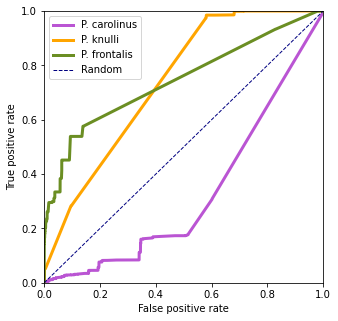

In [5]:
spec_labels=['P. knulli', 'P. frontalis', 'P. carolinus']
fig,ax=plt.subplots(1,1, figsize=(5, 5))
colormap = {0: 'orange', 1: 'olivedrab', 2: 'mediumorchid', 3: 'dodgerblue'}
fprs = []
tprs = []
for i, sp in enumerate([2,0,1]):
    fpr, tpr, thresholds = roc_curve(y_true, y_score[:,sp].flatten(), pos_label=sp)
    lw = 3
    ax.plot(
        fpr,
        tpr,
        color=colormap[sp],
        lw=lw,
        label=spec_labels[sp],
    )
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
ax.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label="Random")
plt.legend()
plt.show()

Plot confusion matrix.

[Text(0, 0.5, 'P. carolinus'),
 Text(0, 1.5, 'P. knulli'),
 Text(0, 2.5, 'P. frontalis')]

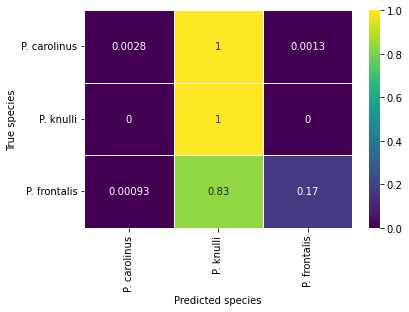

In [6]:
cm2 = np.array([[conf_mat[2,2],conf_mat[2,0],conf_mat[2,1]],
                [conf_mat[0,2],conf_mat[0,0],conf_mat[0,1]],
                [conf_mat[1,2],conf_mat[1,0],conf_mat[1,1]]])

fig,ax = plt.subplots()
sns.heatmap(cm2, linewidths=1, cmap='viridis', ax=ax, annot=True, fmt='.2g')
ax.set_ylabel('True species')
ax.set_xlabel('Predicted species')
ax.set_xticklabels(['P. carolinus', 'P. knulli', 'P. frontalis'], rotation=90)
ax.set_yticklabels(['P. carolinus', 'P. knulli', 'P. frontalis'], rotation=0)

Import results from DTW with population references (using Matlab file dtw_popref.m) and compute classification metrics.

In [ ]:
import matlab.engine
eng = matlab.engine.start_matlab()
eng.dtw_popref(nargout=0)
eng.quit()

Analyze classification results.

In [4]:
y_true = pd.read_csv('dtw_y_true.csv',header=None)
y_pred = pd.read_csv('dtw_y_pred.csv',header=None)
y_score = pd.read_csv('dtw_y_score.csv',header=None)
yt = y_true.to_numpy().reshape((100,int(len(y_true)/100)))
yp = y_pred.to_numpy().reshape((100,int(len(y_pred)/100)))
accs = []
precs = []
recs = []
num_species = 4
num_iter = 100
precs_sp = np.zeros((num_species, num_iter))
recs_sp = np.zeros((num_species,num_iter))
for i in range(100):
    metrics = classification_report(yt[i],yp[i],output_dict=True)
    acc = metrics['accuracy']
    prec = metrics['macro avg']['precision']
    rec = metrics['macro avg']['recall']
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    for sp in range(num_species):
        precs_sp[sp,i] = metrics[str(sp)]['precision']
        recs_sp[sp,i] = metrics[str(sp)]['recall']

Plot confusion matrix.

[Text(0, 0.5, 'Bw'),
 Text(0, 1.5, 'P. carolinus'),
 Text(0, 2.5, 'P. knulli'),
 Text(0, 3.5, 'P. frontalis')]

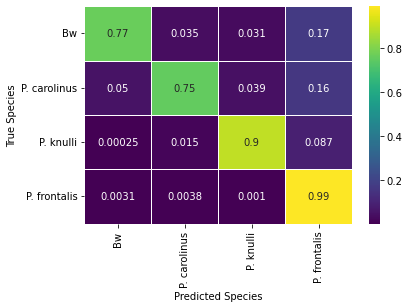

In [5]:
conf_mat = confusion_matrix(y_true,y_pred,normalize='true')
cm2 = np.array([[conf_mat[3,3], conf_mat[3,2],conf_mat[3,0],conf_mat[3,1]],
                [conf_mat[2,3], conf_mat[2,2],conf_mat[2,0],conf_mat[2,1]],
                [conf_mat[0,3], conf_mat[0,2],conf_mat[0,0],conf_mat[0,1]],
                [conf_mat[1,3], conf_mat[1,2],conf_mat[1,0],conf_mat[1,1]]])

fig,ax = plt.subplots()
sns.heatmap(cm2, linewidths=1, cmap='viridis', ax=ax, annot=True, fmt='.2g')
ax.set_ylabel('True Species')
ax.set_xlabel('Predicted Species')
ax.set_xticklabels(['Bw', 'P. carolinus', 'P. knulli', 'P. frontalis'], rotation=90)
ax.set_yticklabels(['Bw', 'P. carolinus', 'P. knulli', 'P. frontalis'], rotation=0)

Plot ROC curves.

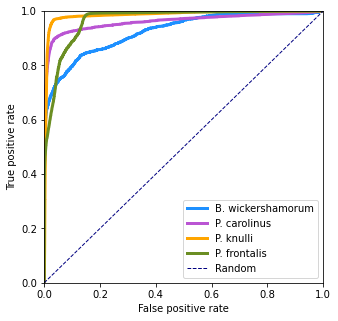

In [7]:
spec_labels=['P. knulli', 'P. frontalis', 'P. carolinus','B. wickershamorum']
fig,ax=plt.subplots(1,1, figsize=(5, 5))
colormap = {0: 'orange', 1: 'olivedrab', 2: 'mediumorchid', 3: 'dodgerblue'}
fprs = []
tprs = []
for i, sp in enumerate([3,2,0,1]):
    fpr, tpr, thresholds = roc_curve(y_true, y_score.to_numpy()[:,sp].flatten(), pos_label=sp)
    lw = 3
    ax.plot(
        fpr,
        tpr,
        color=colormap[sp],
        lw=lw,
        label=spec_labels[sp],
    )
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
ax.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label="Random")
plt.legend()
plt.show()